In [39]:
import glob, serial, time, math
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from skimage.transform import iradon
from IPython.display import display

In [40]:
ports = glob.glob('/dev/tty[A-Za-z]*') # Modify if on a platform other than Linux
ports

['/dev/ttyACM0',
 '/dev/ttyUSB2',
 '/dev/ttyUSB1',
 '/dev/ttyUSB0',
 '/dev/ttyprintk',
 '/dev/ttyS31',
 '/dev/ttyS30',
 '/dev/ttyS29',
 '/dev/ttyS28',
 '/dev/ttyS27',
 '/dev/ttyS26',
 '/dev/ttyS25',
 '/dev/ttyS24',
 '/dev/ttyS23',
 '/dev/ttyS22',
 '/dev/ttyS21',
 '/dev/ttyS20',
 '/dev/ttyS19',
 '/dev/ttyS18',
 '/dev/ttyS17',
 '/dev/ttyS16',
 '/dev/ttyS15',
 '/dev/ttyS14',
 '/dev/ttyS13',
 '/dev/ttyS12',
 '/dev/ttyS11',
 '/dev/ttyS10',
 '/dev/ttyS9',
 '/dev/ttyS8',
 '/dev/ttyS7',
 '/dev/ttyS6',
 '/dev/ttyS5',
 '/dev/ttyS4',
 '/dev/ttyS3',
 '/dev/ttyS2',
 '/dev/ttyS1',
 '/dev/ttyS0']

In [41]:
ser = serial.Serial(ports[0], 115200)

In [8]:
a_steps = 640 # Steps per revolution - 200 * 80/25
b_steps = 1280 # 160 teeth -> 200*160/25

apos = 0
bpos = 0

read = ''

def step_a(n):
    message = b'a'
    if n < 0:
        n = -n
        message = b'A'
    for i in range(n):
        ser.write(message)
        while ser.in_waiting < 1:
            pass # wait for a response
        read = ser.read_all()
#         print(read)
    return n

def set_a(angle):
    step_coords = int(angle/(2*math.pi) * a_steps) # Angle in radians
    step_a(step_coords - apos)
    return step_coords

def step_b(n):
    message = b'b'
    if n < 0:
        n = -n
        message = b'B'
    for i in range(n):
        ser.write(message)
        while ser.in_waiting < 1:
            pass # wait for a response
        read = ser.read_all()
#         print(read)
    return n

def set_b(angle):
    step_coords = int(angle/(2*math.pi) * b_steps) # Angle in radians
    step_b(step_coords - bpos)
    return step_coords

def read_adc():
    ser.write(b'E')
    while ser.in_waiting < 1:
        pass # wait for a response
    return ser.read_all()

def read_adc16():
    ser.write(b'H')
    while ser.in_waiting < 1:
        pass # wait for a response
    return ser.read_all()

# apos = set_a(0.2) # This is the proper usage to keep track
# print(apos)

We can move the A and B axes with step_a(n_steps) or set_a(angle in radians). A is the inner circle, B the outer.

In [64]:
step_a(60)
step_a(-30)
step_a(30)

30

In [62]:
step_b(30)

30

Let's take one really detailed scan using the B axis to see what our beam shape looks like. 0 to 180 degrees by stepping B 640 times (half a revolution) reading the adc 3 times each position and averaging:

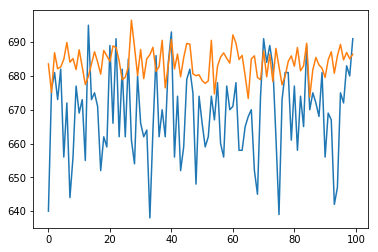

In [304]:
noise = []
s10 = []
for b in range(100):
    val = 0
    for i in range(1):
        val += int(read_adc().strip())
    noise.append(val)
    val2 = 0
    for i in range(1):
        val2 += int(read_adc16().strip())
    s10.append(val2/15)
plt.plot(noise)
plt.plot(s10)

In [305]:
ser.read_all()

b''

A and B are now centered opposite eachother, with the LED opposite the PT

In [57]:
fn = '3nails2'

In [65]:
# Taking one set of readings as a baseline (no object)
step_b(-200)
base = []
for b in range(400):
    base.append(int(read_adc().strip()))
    step_b(1)
step_b(-200)
                
plt.plot(base)
b = pd.DataFrame(base)
b.to_csv(fn + 'base.csv', index = False)

ValueError: invalid literal for int() with base 10: b'STEP B cw'

In [59]:
# Now, doing these scans from several angles. Doing 32 As (views/thetas), 64 Bs for each A (64 sensors)
from IPython.display import clear_output
readings = []
nv=32
nd = 400 # Hard coded for now
for a in range(nv):
    print(a)
    line = []
    step_b(-200)
    for b in range(400):
        line.append(int(read_adc().strip()))
        step_b(1)
    readings.append(line)
    step_a(int(-640/nv)) # A has 640 steps in 360 degrees.
    step_b(-200) # return to start
    
#     plt.plot(line)
#     plt.show()
    clear_output(wait=True)
    
    time.sleep(1)
    

# We return A to start to ensure we haven't missed steps    
# step_a(-640)  

# Save the scan
d = pd.DataFrame(readings)
d.to_csv(fn+'_' + str(nv) + 'v_' + str(nd) + 'd.csv', index=False)

24


KeyboardInterrupt: 

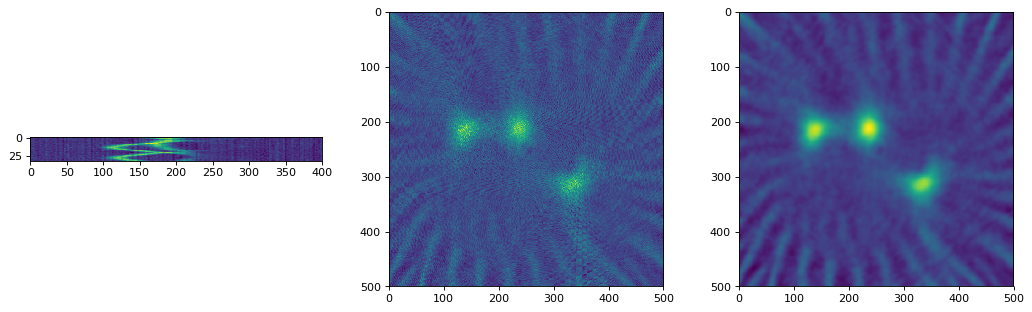

In [54]:
# Import required libraries
from image_util import *
import skimage.filters
from matplotlib import pyplot as plt
import cairocffi as cairo
import math, random
import numpy as np
import pandas as pd
from IPython.display import Image
from scipy.interpolate import interp1d
import astra

%matplotlib inline

# First, set constants and load data

# Constants
dist_d = 60/50 #(70mm)
dist_e = 100/50 #(95mm)
nviews = nv
ndetectors = nd
nvdetectors = nd # Can optionally simulate having fewer detectors by changing this number

# Data
bb = pd.read_csv(fn + 'base.csv')
br = pd.read_csv(fn+'_' + str(nv) + 'v_' + str(nd) + 'd.csv')
readings = np.asarray(br)
base = np.asarray(bb).T
for r in range(len(readings)):
    readings[r] = readings[r]-base

# Defining distances in pixels
IMSIZE = 500
R = dist_d*IMSIZE/2
D = dist_e*IMSIZE/2

# Transforming from a round fan-beam to a fan-flat projection (See diagram)
beta = np.linspace(0, math.pi, nd)
alpha = np.asarray([R*math.sin(b-math.pi/2)/(R**2 + D**2)**0.5 for b in beta])
tau = np.asarray([(R+D)*math.tan(a) for a in alpha])

readings2 = []
tau_new = np.linspace(-(max(tau)/2), 1.75*max(tau)/2, nvdetectors) # Can change bounds. GOod to stick within max

for r in readings:
    f = interp1d(tau, r, kind='cubic') # Can change to linear
    readings2.append(f(tau_new))


# Reconstructing

# Defining the geometry in ASTRA
vol_geom = astra.create_vol_geom(IMSIZE, IMSIZE)
angles = np.linspace(0,2*math.pi,nviews);
d_size = (tau[-1]-tau[0])/nvdetectors
proj_geom= astra.create_proj_geom('fanflat', d_size, nvdetectors, angles, D, R);
proj_id = astra.create_projector('line_fanflat', proj_geom, vol_geom)
sinogram_id = astra.data2d.create('-sino', proj_geom, np.asarray(readings2))

# Plotting sinogram - new (transformed) set of readings
plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
ax1 = plt.subplot(2, 3, 1)
ax1.imshow(readings2) #<< Set title

# Doing the reconstruction, in this case with the SIRT algorithm (can change to 'FBP')
rec_id = astra.data2d.create('-vol', vol_geom)

cfg = astra.astra_dict('SIRT')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sinogram_id
cfg['ProjectorId'] = proj_id

# Create the algorithm object from the configuration structure
alg_id = astra.algorithm.create(cfg)

astra.algorithm.run(alg_id, 20)

# Get the result
rec = astra.data2d.get(rec_id)
ax2 = plt.subplot(2, 3, 2)
ax2.imshow(rec)
norm_rec = rec/np.amax(rec)
blurred = skimage.filters.gaussian(norm_rec, 3)
ax3 = plt.subplot(2, 3, 3)
ax3.imshow(blurred)

plt.savefig(fn+'reconstruction.png')


# Clean up.
astra.algorithm.delete(alg_id)
astra.data2d.delete(rec_id)
astra.data2d.delete(sinogram_id)
astra.projector.delete(proj_id)

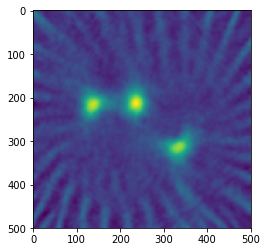

In [55]:
plt.imshow(blurred)
plt.savefig('3nails.png')

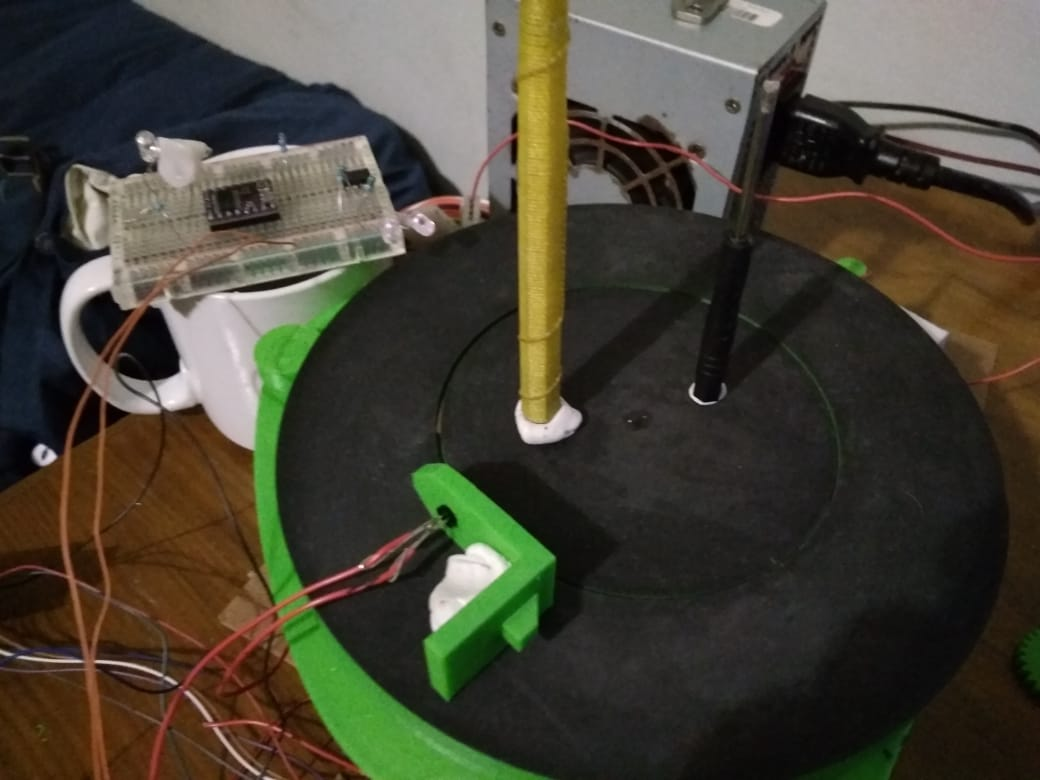

In [27]:
Image('images/two_pens_scanning.jpeg')

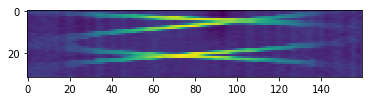

In [22]:
plt.imshow(readings2)
plt.savefig('two_pens_sino.png')

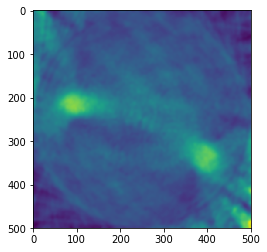

In [21]:
plt.imshow(blurred)
plt.savefig('two_pens_blurred.png')

A plot of noise with and without averaging

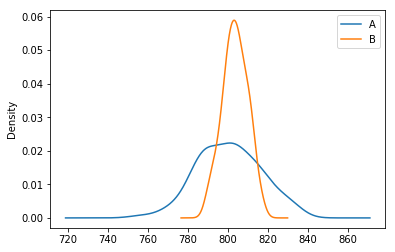

In [417]:
n.plot(kind='density')